In [7]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [8]:
import numpy as np
import pandas as pd
import xgboost as xg
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import preprocessing as pre
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

In [9]:
# nba = common.get_cleaned_baseline_data('./data/cleaned_data/base_cleaned.csv')
nba = pd.read_csv('../data/cleaned_data/external_cleaned.csv')

nba = pre.add_log_y_values(nba)
# nba['inflationAdjSalary_log'] = nba['salary'].apply(lambda x: np.log(x))
nba = nba.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'college','archetype','all_star','all_nba', 'position','team'])
nba = nba.dropna()
nba = nba.loc[:, (nba != 0).any(axis=0)]
# nba = nba.drop(columns=['position','team'])

# y=nba[:,-1]

In [10]:
print(nba.columns)
X_train, X_test, y_train, y_test = pre.split_data(nba)

Index(['seasonStartYear', 'startYear', 'height', 'weight', 'MP', 'PTS', 'Age',
       'games', 'games_started', 'PER', 'FTr', 'AST', 'STL', 'TRB', 'FT', '3P',
       'FG', 'all_star_total', 'all_star_enc', 'all_nba_enc', 'all_nba_total',
       'draft_pick', 'champion', 'conference_champ', 'mvp', 'mvp_rank',
       'mvp_total', 'player_week_enc', 'player_week_total', 'dpoy',
       'dpoy_rank', 'dpoy_total', 'inflationAdjSalary_log'],
      dtype='object')


In [11]:
# feature_names = nba.columns.values.tolist()
# feature_names.remove('playerName')
# feature_names.remove('inflationAdjSalary_log')
# feature_names

In [12]:
#Without hyperparameter tuning

xgb_r = xg.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:squarederror')
  
# Fitting the model
xgb_r.fit(X_train, y_train)
  
# Predict the model
y_pred = xgb_r.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2_s=r2_score(y_test, y_pred)
print("MSE: ",mse)
print("r2_socre: ",r2_s)
print("RMSE: ",rmse)
print("MAE:",mae)

MSE:  0.8186535221703359
r2_socre:  0.4817105484358575
RMSE:  0.9047947403529355
MAE: 0.6600392453345602


In [13]:
# train_dmatrix = xg.DMatrix(data = X_train, label = y_train, feature_names=feature_names)
# test_dmatrix = xg.DMatrix(data = X_test, label = y_test, feature_names=feature_names)
  
# # Parameter dictionary specifying base learner
# param = {"objective":"reg:linear","booster":"gbtree"}
  
# xgb_r = xg.train(params = param, dtrain = train_dmatrix, num_boost_round = 10)
# pred = xgb_r.predict(test_dmatrix)

# params = { 'max_depth': [3,6,10],
#            'learning_rate': [0.01, 0.05, 0.1],
#            'n_estimators': [100, 500, 1000],
#            'colsample_bytree': [0.3, 0.7]}

params = {
    'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:squarederror', 'reg:tweedie'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

# xgbr = xg.XGBRegressor(objective='reg:squarederror', booster='gbtree', seed = 20)
xgbr = xg.XGBRegressor(nthread=-1)
clf = RandomizedSearchCV(estimator = xgbr, 
                         param_distributions=params,
                         n_iter=100, 
                         cv=3, 
                         scoring='neg_mean_squared_error',
                         verbose=2, 
                         random_state=42, 
                         n_jobs = -1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))
print("MSE", -clf.best_score_)
# print("Detailed results: ",clf.cv_results_)
# xgb_r = xg.XGBRegressor(max_depth=3, learning_rate=0.1, n_estimators=500, objective='reg:squarederror', booster='gbtree')
  
# # Fitting the model
# xgb_r.fit(X_train, y_train)
best_random = clf.best_estimator_
y_pred = best_random.predict(X_test)
# # Predict the model
# pred = xgb_r.predict(X_test)
  
# # RMSE Computation
# rmse = np.sqrt(mean_squared_error(y_test, pred))
# print("RMSE : % f" %(rmse))

# MSE = mean_squared_error(y_test, pred)
# r2 = r2_score(y_test, pred)

# print(f"MSE: {MSE}, R2: {r2}")
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2_s=r2_score(y_test, y_pred)
print("MSE: ",mse)
print("r2_socre: ",r2_s)
print("RMSE: ",rmse)
print("MAE:",mae)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[14:09:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[14:09:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[14:09:33] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample" } are not used.

[CV] END booster=gblinear, colsample_bytree=0.9, eta=0.5, eval_metric=rmse, gamma=0.4, max_depth=4, min_child_weight=4, n_estimators=500, objective=reg:squarederror, subsample=0.6; total time=   0.3s
[C

In [14]:
# feature_important = best_random.get_booster().get_score(importance_type='weight')
# feature_important
# keys = list(feature_important.keys())
# values = list(feature_important.values())

# data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
# data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [15]:
Predictors=['seasonStartYear','startYear','height','weight','MP','PTS','Age','games','games_started','PER','FTr','AST','STL','TRB','FT','3P','FG','all_star_total','all_star_enc','all_nba_enc','all_nba_total','draft_pick','champion','conference_champ','mvp','mvp_rank','mvp_total','player_week_enc','player_week_total','dpoy','dpoy_rank','dpoy_total']
feature_importances = pd.Series(xgb_r.feature_importances_, index=Predictors)
feature_importances.plot(kind='barh')

ValueError: Length of values (31) does not match length of index (32)

In [16]:
Predictors=['seasonStartYear','startYear','height','weight','MP','PTS','Age','games','games_started','PER','FTr','AST','STL','TRB','FT','3P','FG','all_star_total','all_star_enc','all_nba_enc','all_nba_total','draft_pick','champion','conference_champ','mvp','mvp_rank','mvp_total','player_week_enc','player_week_total','dpoy','dpoy_rank','dpoy_total']
feature_importances = pd.Series(best_random.feature_importances_, index=Predictors)
feature_importances.plot(kind='barh')

ValueError: Length of values (31) does not match length of index (32)

In [17]:
!pip3 install shap


You should consider upgrading via the '/Users/tsedeniyaamare/.pyenv/versions/3.10.0/bin/python3.10 -m pip install --upgrade pip' command.


In [18]:
import shap

explainer = shap.Explainer(xgb_r)

In [19]:
shap_values = shap.TreeExplainer(xgb_r).shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


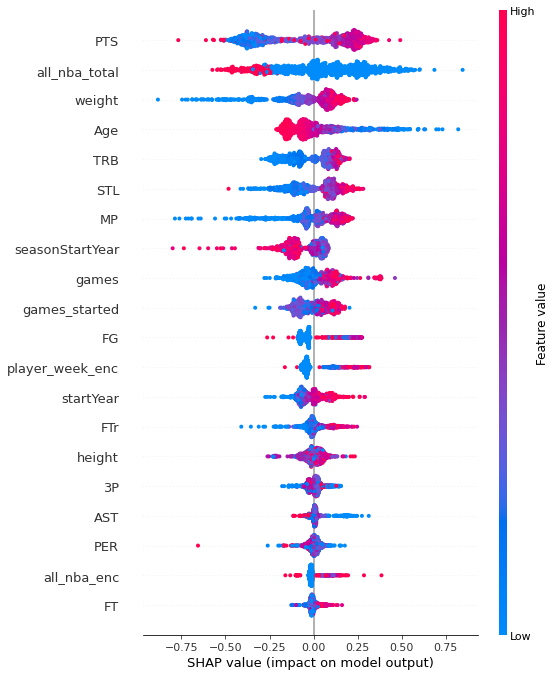

In [20]:
shap.summary_plot(shap_values, X_test,feature_names=Predictors)

shap.dependence_plot("Age", shap_values, X_test,feature_names=Predictors)